# Data Science Challenge

Structure of the script:
1.  Load all needed libraries and functions.
2.  Load data, do preliminary data exploration. Create/delete variables.
3.  Deal with missing values.
4.  Do visualization, transform skewed variables.
5.  Trnasform features depending on their type. OHC.
6.  Create subsamples.
7.  Do scaling.
8.  Fit models, selecting hyperparameters via CV grid search.
9.  Test accuracy OOS, then export predictions.

### 1.Load main libraries ###

In [5]:
import sys
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.inspection import permutation_importance

# cannot import permutation_importance from sklearn.
# i have reinstalled sklearn, yet the same problem...

pd.set_option("display.max_columns", 101)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.expand_frame_repr', False)

In [2]:
# function to get multiple historgrams
def draw_histograms(df, variables, n_rows, n_cols):
    # stolen from https://stackoverflow.com/questions/29530355/plotting-multiple-histograms-in-grid
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  
    plt.show()

In [3]:
# another attempt to turn off warnings
import warnings
warnings.filterwarnings("ignore")

### Data Description

Column | Description
:---|:---
`id` | The unique ID assigned to every hotel.
`region` | The region in which the hotel is located..
`latitude` | The latitude of the hotel.
`longitude` | The longitude of the hotel.
`accommodation_type` | The type of accommodation offered by the hotel. For example: Private room, Entire house/apt, etc.
`cost` | The cost of booking the hotel for one night. (in \$\$)
`minimum_nights` | The minimum number of nights stay required.
`number_of_reviews` | The number of reviews accumulated by the hotel.
`reviews_per_month` | The average number of reviews received by the hotel per month.
`owner_id` | The unique ID assigned to every owner. An owner can own multiple hotels.
`owned_hotels` | The number of hotels owned by the owner.
`yearly_availability` | It indicates if the hotel accepts bookings around the year. Values are 0 (not available for 365 days in a year) and 1 (available for 365 days in a year).

### 2.  Load data, do preliminary data exploration. Create/delete variables.

In [6]:
# Dataset is already loaded below

data = pd.read_csv("../input/hackerrank-availability/train (5).csv")
data.head(3)

,id,region,latitude,longitude,accommodation_type,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,yearly_availability
0,13232,Manhattan,40.71854,-74.00439,Entire home/apt,170,5,7,0.56,929983,1,0
1,246,Brooklyn,40.64446,-73.95030,Entire home/apt,65,3,238,2.30,281764,1,0
2,19091,Queens,40.78573,-73.81062,Private room,85,1,0,NaN,19923341,1,1


In [ ]:
data.info()
# all y values are nonmissing. so after concatentaing train and test all missing values will correspond to test sample.

In [7]:
### Loading test data, combining train and test ###
#      I will combine train and test in this step to simplify feature engineering later #
test_data=pd.read_csv('../input/hackerrank-availability/test (2).csv')
test_data.head(3)

,id,region,latitude,longitude,accommodation_type,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels
0,19215,Brooklyn,40.70912,-73.94513,Shared room,135,2,22,0.66,4360212,1
1,36301,Brooklyn,40.57646,-73.96641,Entire home/apt,69,2,8,0.90,181356989,2
2,40566,Manhattan,40.76616,-73.98228,Private room,225,30,0,NaN,13773574,12


In [8]:
print(data.shape, test_data.shape)
train = data.copy()
test = test_data.copy()
train['sample']='train'
test['yearly_availability'] = np.nan
test['sample']='test'
print(train.columns==test.columns)
# good, so we can concatenate train and test.

(2870, 12) (718, 11)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True]


In [9]:
df=pd.concat([train, test])
df.reset_index(inplace=True, drop=True)
print(data.shape)
df.head(3)

(2870, 12)


,id,region,latitude,longitude,accommodation_type,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,yearly_availability,sample
0,13232,Manhattan,40.71854,-74.00439,Entire home/apt,170,5,7,0.56,929983,1,0.0,train
1,246,Brooklyn,40.64446,-73.95030,Entire home/apt,65,3,238,2.30,281764,1,0.0,train
2,19091,Queens,40.78573,-73.81062,Private room,85,1,0,NaN,19923341,1,1.0,train


In [10]:
# here I will take a look at the distribution of features, both categorical and numerical.

num_cols = ['id','latitude', 'longitude', 'cost', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'owner_id', 'owned_hotels']
#cat_cols = ['accommodation_type', 'region']

print(df['accommodation_type'].value_counts())
print(df['region'].value_counts())
print(df.shape)
df[num_cols].describe()

Private room       1512
Entire home/apt    1249
Shared room         827
Name: accommodation_type, dtype: int64
Manhattan        1665
Brooklyn         1360
Queens            442
Bronx             101
Staten Island      20
Name: region, dtype: int64
(3588, 13)


,id,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels
count,3588.000000,3588.000000,3588.000000,3588.000000,3588.000000,3588.000000,2739.000000,3.588000e+03,3588.000000
mean,26990.550725,40.730813,-73.950725,193.460981,11.628763,15.999164,1.166035,7.329604e+07,8.450111
std,14152.926962,0.055104,0.049300,402.121986,42.184018,31.443654,1.370105,8.157871e+07,27.239514
min,0.000000,40.499790,-74.242850,10.000000,1.000000,0.000000,0.010000,2.787000e+03,1.000000
25%,16083.750000,40.691607,-73.983695,75.000000,1.000000,1.000000,0.250000,7.464408e+06,1.000000
50%,29276.500000,40.727690,-73.956825,120.000000,3.000000,4.000000,0.650000,3.442499e+07,1.000000
75%,38669.250000,40.762985,-73.935090,199.000000,6.000000,16.000000,1.530000,1.249756e+08,3.000000
max,48893.000000,40.898730,-73.721730,9999.000000,1250.000000,395.000000,10.370000,2.738123e+08,327.000000


### 3.Deal with missing values ###

In [11]:
#%% 3.Deal with missing values ###

df.info()
# review_per_month is the only feature with missing values. 
# lets impute values by its mean, since I do not want to lose 25% of the sample by dropping missing observations.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588 entries, 0 to 3587
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   3588 non-null   int64  
 1   region               3588 non-null   object 
 2   latitude             3588 non-null   float64
 3   longitude            3588 non-null   float64
 4   accommodation_type   3588 non-null   object 
 5   cost                 3588 non-null   int64  
 6   minimum_nights       3588 non-null   int64  
 7   number_of_reviews    3588 non-null   int64  
 8   reviews_per_month    2739 non-null   float64
 9   owner_id             3588 non-null   int64  
 10  owned_hotels         3588 non-null   int64  
 11  yearly_availability  2870 non-null   float64
 12  sample               3588 non-null   object 
dtypes: float64(4), int64(6), object(3)
memory usage: 364.5+ KB


In [12]:
avg_reviews = df["reviews_per_month"].astype("float").mean(axis = 0)
df["reviews_per_month"].replace(np.nan, avg_reviews, inplace = True)
df.info()
# the only missing values are Y variable for test sample, as expected.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588 entries, 0 to 3587
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   3588 non-null   int64  
 1   region               3588 non-null   object 
 2   latitude             3588 non-null   float64
 3   longitude            3588 non-null   float64
 4   accommodation_type   3588 non-null   object 
 5   cost                 3588 non-null   int64  
 6   minimum_nights       3588 non-null   int64  
 7   number_of_reviews    3588 non-null   int64  
 8   reviews_per_month    3588 non-null   float64
 9   owner_id             3588 non-null   int64  
 10  owned_hotels         3588 non-null   int64  
 11  yearly_availability  2870 non-null   float64
 12  sample               3588 non-null   object 
dtypes: float64(4), int64(6), object(3)
memory usage: 364.5+ KB


### 4. Visualization, rescaling

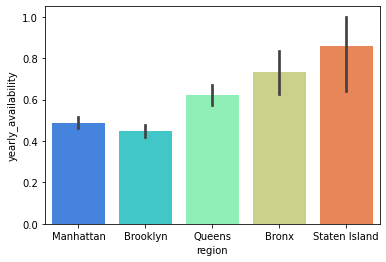

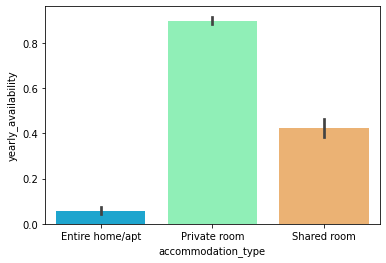

In [19]:
# visualization for catergorical features:

sns.barplot(x='region',y='yearly_availability',data=df, palette='rainbow')
plt.show()
sns.barplot(x='accommodation_type',y='yearly_availability',data=df, palette='rainbow')
plt.show()

Accomodation type is very important determinant of availability!

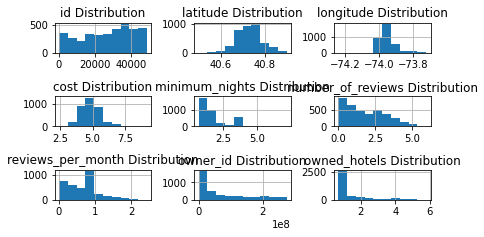

In [22]:
# visualization for numerical variables
#sns.regplot(x="cost", y="yearly_availability", data=df)
draw_histograms(df, num_cols, 4, 3)

In [13]:
#%% Transform some skewed variables [optional] ###

df['cost'] = np.log1p(df.cost)
df['minimum_nights'] = np.log1p(df.minimum_nights)
df['number_of_reviews'] = np.log1p(df.number_of_reviews)
df['reviews_per_month'] = np.log1p(df.reviews_per_month)
df['owned_hotels'] = np.log1p(df.owned_hotels)

In [14]:
df[num_cols].describe()

,id,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels
count,3588.000000,3588.000000,3588.000000,3588.000000,3588.000000,3588.000000,3588.000000,3.588000e+03,3588.000000
mean,26990.550725,40.730813,-73.950725,4.843685,1.647294,1.782912,0.664859,7.329604e+07,1.275776
std,14152.926962,0.055104,0.049300,0.780500,1.054720,1.438214,0.437977,8.157871e+07,1.013399
min,0.000000,40.499790,-74.242850,2.397895,0.693147,0.000000,0.009950,2.787000e+03,0.693147
25%,16083.750000,40.691607,-73.983695,4.330733,0.693147,0.693147,0.307485,7.464408e+06,0.693147
50%,29276.500000,40.727690,-73.956825,4.795791,1.386294,1.609438,0.717840,3.442499e+07,0.693147
75%,38669.250000,40.762985,-73.935090,5.298317,1.945910,2.833213,0.772898,1.249756e+08,1.386294
max,48893.000000,40.898730,-73.721730,9.210340,7.131699,5.981414,2.430978,2.738123e+08,5.793014


### 5.Transform features depending on their type ###

In [23]:
#%% 4.Transform features depending on their type ###

# there are few features here, so can do this step manually.

categorical_variables = ['accommodation_type', 'region']
numeric_variables = num_cols.copy()

print('Categorical variables are ', categorical_variables)
print('Numeric variables are ', numeric_variables)

Categorical variables are  ['accommodation_type', 'region']
Numeric variables are  ['id', 'latitude', 'longitude', 'cost', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'owner_id', 'owned_hotels']


In [24]:
# ohc for categorical variables #
df = pd.get_dummies(df, columns = categorical_variables, drop_first=True)

print(df.shape)
print(df.dtypes)
df.head(3)

(3588, 17)
id                                   int64
latitude                           float64
longitude                          float64
cost                               float64
minimum_nights                     float64
number_of_reviews                  float64
reviews_per_month                  float64
owner_id                             int64
owned_hotels                       float64
yearly_availability                float64
sample                              object
accommodation_type_Private room      uint8
accommodation_type_Shared room       uint8
region_Brooklyn                      uint8
region_Manhattan                     uint8
region_Queens                        uint8
region_Staten Island                 uint8
dtype: object


,id,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,yearly_availability,sample,accommodation_type_Private room,accommodation_type_Shared room,region_Brooklyn,region_Manhattan,region_Queens,region_Staten Island
0,13232,40.71854,-74.00439,5.141664,1.791759,2.079442,0.444686,929983,0.693147,0.0,train,0,0,0,1,0,0
1,246,40.64446,-73.95030,4.189655,1.386294,5.476464,1.193922,281764,0.693147,0.0,train,0,0,1,0,0,0
2,19091,40.78573,-73.81062,4.454347,0.693147,0.000000,0.772898,19923341,0.693147,1.0,train,1,0,0,0,1,0


### 6.Creating subsamples ###

In [26]:
# %% 5.Creating subsamples ###

train = df[df['sample']=='train'].copy()
train.drop(columns=['sample'], inplace=True)
test = df[df['sample']=='test'].copy()
test.drop(columns=['sample'], inplace=True)

print(train.shape)
print(test.shape)
train.head(3)

(2870, 16)
(718, 16)


,id,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,yearly_availability,accommodation_type_Private room,accommodation_type_Shared room,region_Brooklyn,region_Manhattan,region_Queens,region_Staten Island
0,13232,40.71854,-74.00439,5.141664,1.791759,2.079442,0.444686,929983,0.693147,0.0,0,0,0,1,0,0
1,246,40.64446,-73.95030,4.189655,1.386294,5.476464,1.193922,281764,0.693147,0.0,0,0,1,0,0,0
2,19091,40.78573,-73.81062,4.454347,0.693147,0.000000,0.772898,19923341,0.693147,1.0,1,0,0,0,1,0


In [27]:
y_train = train['yearly_availability']
X_train = train.drop(columns=['yearly_availability'])
X_test = test.drop(columns=['yearly_availability'])

print(X_train.shape)
X_train.head(3)

(2870, 15)


,id,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,accommodation_type_Private room,accommodation_type_Shared room,region_Brooklyn,region_Manhattan,region_Queens,region_Staten Island
0,13232,40.71854,-74.00439,5.141664,1.791759,2.079442,0.444686,929983,0.693147,0,0,0,1,0,0
1,246,40.64446,-73.95030,4.189655,1.386294,5.476464,1.193922,281764,0.693147,0,0,1,0,0,0
2,19091,40.78573,-73.81062,4.454347,0.693147,0.000000,0.772898,19923341,0.693147,1,0,0,0,1,0


### 7. Scaling numerical features ###

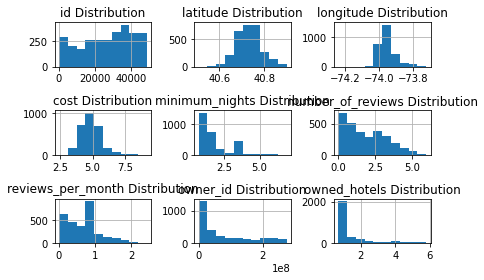

In [28]:
# %% 6.scaling numeric variables ###

draw_histograms(X_train, numeric_variables, 3, 3)

As we can see, several features are approximately normal. Tho other features are not normally ditributed, but do no have extremely fat tails. This is probably the case due to log-tranform, done earlier.
Overall, it seems reasonable to use standard scaler here.

In [30]:
ss = StandardScaler()

for column in [numeric_variables]:
    X_train[column] = ss.fit_transform(X_train[column])
    X_test[column] = ss.transform(X_test[column])
    
X_train.head(3)

,id,latitude,longitude,cost,minimum_nights,number_of_reviews,reviews_per_month,owner_id,owned_hotels,accommodation_type_Private room,accommodation_type_Shared room,region_Brooklyn,region_Manhattan,region_Queens,region_Staten Island
0,-0.956869,-0.230897,-1.090408,0.365183,0.132380,0.202184,-0.498621,-0.880384,-0.573168,0,0,0,1,0,0
1,-1.875356,-1.579468,-0.002863,-0.851317,-0.250664,2.555846,1.215614,-0.888411,-0.573168,0,0,1,0,0,0
2,-0.542467,0.992246,2.805573,-0.513086,-0.905482,-1.238579,0.252321,-0.645175,-0.573168,1,0,0,0,1,0


## 8.Fit models 

### In this step I will try several model families, using grid search to pick the best hyperparameters.

In [31]:
#%% Logistic regression ###

grid_values = {'penalty': ['l2'], 'C': list(np.arange(1,15,1))}
lr = LogisticRegression()
model_lr = GridSearchCV(lr, param_grid=grid_values, cv = 5)
model_lr.fit(X_train, y_train)
print(model_lr.best_score_, model_lr.best_params_)

0.905226480836237 {'C': 5, 'penalty': 'l2'}


In [32]:
#%% KNN ###

grid_values = dict(n_neighbors=np.arange(2,11,1))
knnm = KNeighborsClassifier()   
model_knn = GridSearchCV(knnm, param_grid=grid_values, cv = 5)
model_knn.fit(X_train, y_train)
print(model_knn.best_score_, model_knn.best_params_)

0.8874564459930314 {'n_neighbors': 5}


In [33]:
#%% SVM ###

grid_values = {'C': np.arange(2, 5, 0.2)} 
svmm = svm.SVC(kernel='rbf')
model_svm = GridSearchCV(svmm, param_grid=grid_values, cv = 5)
model_svm.fit(X_train, y_train)
print(model_svm.best_score_, model_svm.best_params_)

0.9271777003484318 {'C': 2.6000000000000005}


In [34]:
#%% RF ###

# may look here: https://www.geeksforgeeks.org/hyperparameter-tuning/

grid_values = [{'max_depth': list(range(4, 9, 1)), 'max_features': list(np.arange(0.3,0.61,0.1))}]
rfc = RandomForestClassifier(random_state=42)
model_rf = GridSearchCV(rfc, grid_values, cv = 5, scoring='accuracy')
model_rf.fit(X_train, y_train)
print(model_rf.best_score_, model_rf.best_params_)

0.929965156794425 {'max_depth': 8, 'max_features': 0.3}


In [36]:
### Boosted Trees ###

estimator = XGBClassifier(
    nthread=8,
    seed=42,
    use_label_encoder=False
)

parameters = {
    'max_depth': range (2, 5, 1),
    'learning_rate': [0.1, 0.15, 0.2]
}

boosted_tree = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 8,
    cv = 5,
    verbose=True
)

boosted_tree.fit(X_train, y_train, eval_metric='rmse')
print(boosted_tree.best_score_, boosted_tree.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.9771829388825012 {'learning_rate': 0.15, 'max_depth': 3}


In [37]:
ml_results = pd.DataFrame(columns=['model', 'accuracy'])
ml_results.model = ['Logistic', 'KNN', 'SVM', 'RandomForest', 'boostedTree']
ml_results.accuracy = [model_lr.best_score_, model_knn.best_score_, model_svm.best_score_, model_rf.best_score_, boosted_tree.best_score_]

ml_results
#bt_score = boosted_tree.best_score_

,model,accuracy
0,Logistic,0.905226
1,KNN,0.887456
2,SVM,0.927178
3,RandomForest,0.929965
4,boostedTree,0.977183


<AxesSubplot:xlabel='model', ylabel='accuracy'>

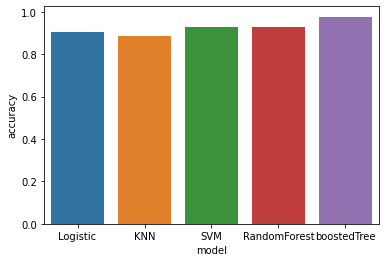

In [38]:
sns.barplot(x='model', y='accuracy', data=ml_results)

Out of 5 families of models, Boosted tree performs best.
Simpler SVM performs pretty well as well. I guess that improvement in performance of boosted tree over SVM is enough to offset higher complexity, so I pick boosted tree model.



**Highlight the most important features of the model for management.**

> #### Task:
- **Visualize the top 20 features and their feature importance.**


In [ ]:
# for some reason, i cannot import permutation_importance from sklearn...

In [39]:
# the simplest way to explore feature importance is to check coefficients from a linear model:

lrg = LogisticRegression()
lrg.fit(X_train, y_train)

feat_imp = pd.DataFrame(columns=['feature', 'importance'])
feat_imp.feature = list(X_train.columns)
feat_imp.importance = np.abs(lrg.coef_.flatten())
feat_imp.replace("accommodation_type_Private room", 'Private room', inplace = True)
feat_imp.replace("accommodation_type_Shared room", 'Shared room', inplace = True)
feat_imp

LogisticRegression()

<AxesSubplot:xlabel='feature', ylabel='importance'>

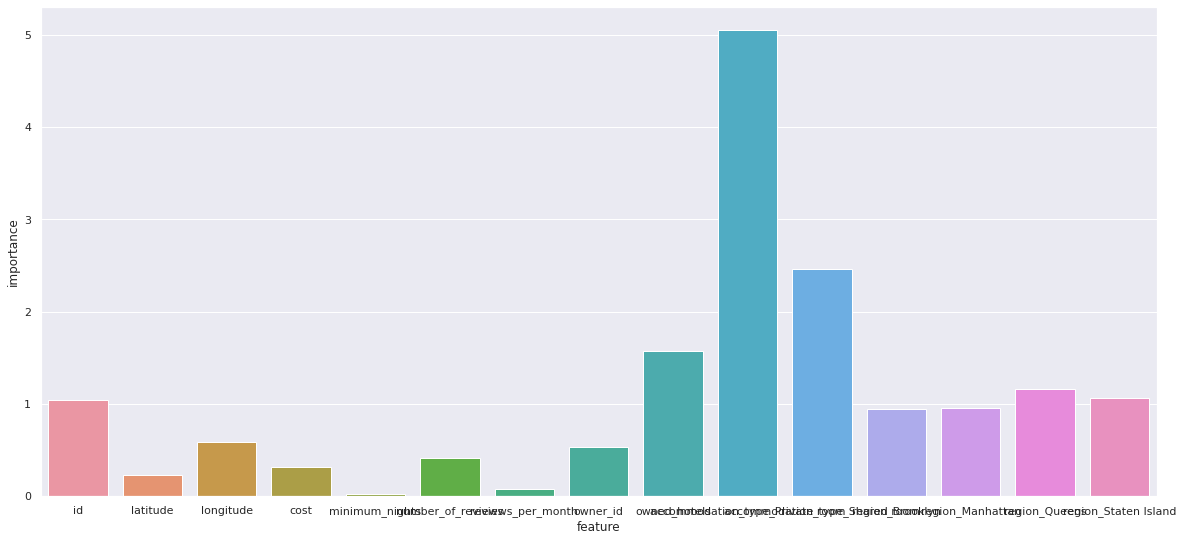

In [64]:
sns.set(rc={'figure.figsize':(20,9)})
sns.barplot(x='feature', y='importance', data=feat_imp)

### 8. Export predictions ###

> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    For each record in the test set (`test.csv`), predict the value of the `yearly_availability` variable. Submit a CSV file with a header row and one row per test entry.

The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **yearly_availability**

In [ ]:
### 8. Export predictions ###
yhat_bt = boosted_tree.predict(X_test)

In [ ]:
yhat_bt[0:20]

In [ ]:
submissions_df = pd.DataFrame({'id': test.id, 'yearly_availability': yhat_svm}, columns=['id', 'yearly_availability'])
submissions_df

In [ ]:
#Submission
submissions_df.to_csv('submissions.csv',index=False)

---